# **Russian Alcohol Consumption Analysis**

This project analyzes the consumption of different types of alcoholic beverages in Russia from 1998 to 2023. It uses time series analysis to understand the relationships between the consumption of different beverages and to forecast future consumption.

### **Load the Dataset**

The first step is to load the dataset from the CSV file into a pandas DataFrame.


In [74]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error

In [75]:
try:
    df_long = pd.read_csv('Consumption of alcoholic beverages in Russia 1998-2023.csv')
    print("Dataset loaded successfully.")
    print("Original data format (first 5 rows):")
    print(df_long.head())
except FileNotFoundError:
    print("Error: Make sure the CSV file is in the correct directory.")
    exit()

Dataset loaded successfully.
Original data format (first 5 rows):
   Type  Year  Consumption of alcoholic beverages (in liters per capita)  \
0  Wine  1998                                                3.5           
1  Wine  1999                                                3.4           
2  Wine  2000                                                3.6           
3  Wine  2001                                                3.9           
4  Wine  2002                                                4.3           

   Consumption of alcoholic beverages (in liters of pure alcohol per capita)  
0                                               0.42                          
1                                               0.41                          
2                                               0.43                          
3                                               0.47                          
4                                               0.52                          


### **Clean Column Names**

The column names are cleaned to make them easier to work with.


In [76]:
df_long.rename(columns={
    'Type': 'beverage_type',
    'Year': 'year',
    'Consumption of alcoholic beverages (in liters of pure alcohol per capita)': 'consumption_pure_alcohol'
}, inplace=True)

df_long = df_long[['year', 'beverage_type', 'consumption_pure_alcohol']]

### **Pivot from Long to Wide Format**

This is the core action. We set 'year' as the new index, create new columns from the unique values in 'beverage_type', and fill the table with the 'consumption_pure_alcohol' values.


In [77]:
df_wide = df_long.pivot(
    index='year',
    columns='beverage_type',
    values='consumption_pure_alcohol'
)

df_wide.columns.name = None

### **Display the Result**

The resulting DataFrame is displayed.

In [78]:
print(df_wide.head())

      Beer and Сider  Brandy  Sparkling wine  Vodka and Liqueurs  Wine
year                                                                  
1998            1.38    0.12            0.14                5.88  0.42
1999            1.53    0.08            0.13                6.08  0.41
2000            1.79    0.12            0.14                5.84  0.43
2001            2.18    0.12            0.16                5.72  0.47
2002            2.44    0.16            0.14                5.80  0.52


### **Diagnosis with the Augmented Dickey-Fuller (ADF) Test**

The ADF test is used to check if the time series are stationary. A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most time series models require the data to be stationary.


In [79]:
for column in df_wide.columns:
    # The adfuller() function returns several values, but we're most interested in the p-value.
    result = adfuller(df_wide[column])
    p_value = result[1]

    print(f'\nTest for: {column}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {p_value:.4f}')

    # We interpret the p-value against a significance level (e.g., 0.05).
    if p_value > 0.05:
        print("Result: The series is likely NON-STATIONARY.")
    else:
        print("Result: The series is likely STATIONARY.")


Test for: Beer and Сider
ADF Statistic: -5.1030
p-value: 0.0000
Result: The series is likely STATIONARY.

Test for: Brandy
ADF Statistic: -0.9804
p-value: 0.7603
Result: The series is likely NON-STATIONARY.

Test for: Sparkling wine
ADF Statistic: -2.5159
p-value: 0.1117
Result: The series is likely NON-STATIONARY.

Test for: Vodka and Liqueurs
ADF Statistic: -0.4169
p-value: 0.9072
Result: The series is likely NON-STATIONARY.

Test for: Wine
ADF Statistic: -1.8436
p-value: 0.3590
Result: The series is likely NON-STATIONARY.


### **Treatment with Differencing**

Since most of the time series are non-stationary, we apply a first-order differencing to stabilize the mean. Differencing is a transformation that computes the difference between consecutive observations.

In [80]:
print("\n\n--- Applying Treatment (First-Order Differencing) ---")
df_stationary = df_wide.diff().dropna()

print("Differenced data (first 5 rows):")
print(df_stationary.head())



--- Applying Treatment (First-Order Differencing) ---
Differenced data (first 5 rows):
      Beer and Сider  Brandy  Sparkling wine  Vodka and Liqueurs  Wine
year                                                                  
1999            0.15   -0.04           -0.01                0.20 -0.01
2000            0.26    0.04            0.01               -0.24  0.02
2001            0.39    0.00            0.02               -0.12  0.04
2002            0.26    0.04           -0.02                0.08  0.05
2003            0.20    0.00            0.02                0.20  0.08


### **Verification**

We re-run the ADF test on the differenced data to confirm that the series are now stationary.

In [81]:
print("\n\n--- Verifying Stationarity of Transformed Data ---")
for column in df_stationary.columns:
    result = adfuller(df_stationary[column])
    p_value = result[1]

    print(f'\nTest for: {column}')
    print(f'p-value: {p_value:.4f}')

    if p_value > 0.05:
        print("Result: The series is likely NON-STATIONARY.")
    else:
        print("Result: The series is likely STATIONARY.")



--- Verifying Stationarity of Transformed Data ---

Test for: Beer and Сider
p-value: 0.1278
Result: The series is likely NON-STATIONARY.

Test for: Brandy
p-value: 0.0000
Result: The series is likely STATIONARY.

Test for: Sparkling wine
p-value: 0.4061
Result: The series is likely NON-STATIONARY.

Test for: Vodka and Liqueurs
p-value: 0.0027
Result: The series is likely STATIONARY.

Test for: Wine
p-value: 0.0472
Result: The series is likely STATIONARY.


### **Granger Causality Analysis**

Granger causality is a statistical concept of causality that is used to test for a causal relationship between two time series. It tests whether the past values of one time series can be used to predict the future values of another time series.

In [ ]:
max_lag = 3  # We'll test for relationships up to 3 years in the past.
variables = df_stationary.columns
results_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

# Iterate through each column as the response variable (Y)
for caused_var in variables:
    # Iterate through each column as the predictor variable (X)
    for causing_var in variables:
        if caused_var != causing_var:
            # The test requires a 2D array of the two series
            test_data = df_stationary[[caused_var, causing_var]]
            
            # Run the test. The 'verbose=False' argument keeps the output clean.
            test_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
            
            # Find the minimum p-value among all lags tested
            min_p_value = np.min([result[0]['ssr_ftest'][1] for result in test_result.values()])
            
            results_matrix.loc[caused_var, causing_var] = min_p_value

results_matrix.index.name = 'Variable being Caused (Y)'
results_matrix.columns.name = 'Variable doing the Causing (X)'

print(f"\nGranger Causality p-value Matrix (max_lag = {max_lag}):")
print(results_matrix.round(4))

--- Running Granger Causality Tests ---

Granger Causality p-value Matrix (max_lag = 3):
Variable doing the Causing (X)  Beer and Сider  Brandy  Sparkling wine  \
Variable doing the Causing (X)                                           
Beer and Сider                          0.0000  0.1546          0.1684   
Brandy                                  0.0010  0.0000          0.1009   
Sparkling wine                          0.0613  0.3520          0.0000   
Vodka and Liqueurs                      0.6962  0.7486          0.1899   
Wine                                    0.0696  0.0680          0.1119   

Variable doing the Causing (X)  Vodka and Liqueurs    Wine  
Variable doing the Causing (X)                              
Beer and Сider                              0.2539  0.1588  
Brandy                                      0.4237  0.1971  
Sparkling wine                              0.1155  0.7883  
Vodka and Liqueurs                          0.0000  0.7731  
Wine                      

/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarn

### **Calculate the Correlation Matrix**

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. The value is in the range of -1 to 1. A value of 1 implies that a linear equation describes the relationship between two variables perfectly, with all data points lying on a line for which Y increases as X increases. A value of -1 implies that all data points lie on a line for which Y decreases as X increases. A value of 0 implies that there is no linear correlation between the variables.

In [83]:
correlation_matrix = df_stationary.corr()

### **Plot the Heatmap**

A heatmap is a graphical representation of data where the individual values contained in a matrix are represented as colors. The heatmap makes it easy to visualize complex data and understand it at a glance.

Correlation matrix heatmap has been saved as 'correlation_heatmap.png'


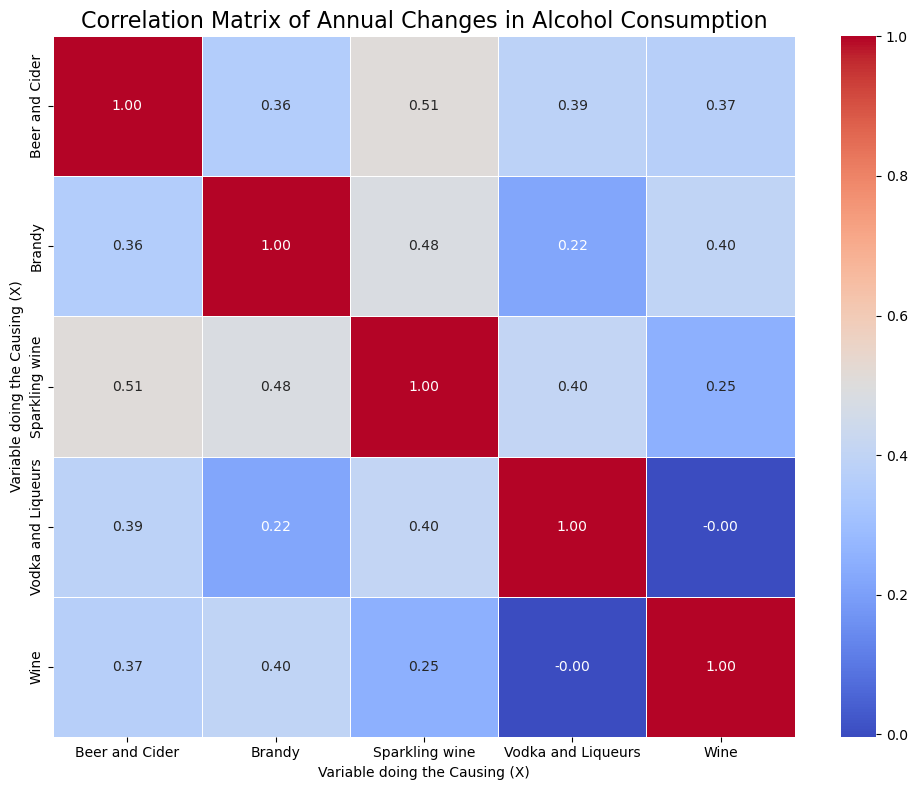

In [84]:
plt.figure(figsize=(10, 8)) # Set the size of the figure for better readability
sns.heatmap(
    correlation_matrix,
    annot=True,          # Display the correlation values on the map
    cmap='coolwarm',     # Use a color map that clearly shows positive (warm) and negative (cool) correlations
    fmt=".2f",           # Format the numbers to two decimal places
    linewidths=.5
)

plt.title('Correlation Matrix of Annual Changes in Alcohol Consumption', fontsize=16)
plt.tight_layout() # Adjust layout to make sure everything fits without overlapping

plt.savefig('correlation_heatmap.png')

print("Correlation matrix heatmap has been saved as 'correlation_heatmap.png'")

### **Model Selection: Find the Optimal Lag Order**

A crucial step in VAR modeling is to determine how many past observations (lags) to include. We can use the model's built-in selection tool for this.

In [85]:
model = VAR(df_stationary)
# We test up to a maximum of 3 lags and select the one that minimizes the AIC (Akaike Information Criterion).
selected_order = model.select_order(maxlags=3)
lag_order = selected_order.aic
print(f"Optimal lag order selected by AIC: {lag_order}")

Optimal lag order selected by AIC: 3


### **Model Fitting (Training)**

The VAR model is trained on the stationary data using the optimal lag order.

In [86]:
results = model.fit(lag_order)
# print(results.summary())

### **Forecasting**

The model is used to forecast the next 5 years of alcohol consumption.

In [87]:
# The model requires the last 'lag_order' observations to start forecasting.
last_observations = df_stationary.values[-lag_order:]
forecast_steps = 5 # Let's forecast the next 5 years.

# The forecast() method predicts the future values of the *differenced* series.
forecast_diff = results.forecast(y=last_observations, steps=forecast_steps)
# The output is an array. Let's convert it to a DataFrame for easier handling.
df_forecast_diff = pd.DataFrame(forecast_diff,
                                index=pd.RangeIndex(start=df_wide.index[-1] + 1, stop=df_wide.index[-1] + 1 + forecast_steps),
                                columns=df_stationary.columns)

### **Inverting the Transformation**

This is the most critical step for interpretation. We must reverse the differencing to get our forecast back into the original scale (liters per capita).

In [88]:
last_actual_values = df_wide.iloc[-1]
df_forecast = df_forecast_diff.cumsum() + last_actual_values

### **Visualization**

The historical data and the forecasted data are plotted to visualize the results.


Forecast generated and plot saved as 'consumption_forecast.png'

Forecasted Values (in Liters per Capita):
Variable doing the Causing (X)  Beer and Сider  Brandy  Sparkling wine  \
2024                                      2.75    0.38            0.21   
2025                                      2.58    0.41            0.22   
2026                                      2.20    0.38            0.23   
2027                                      1.94    0.37            0.23   
2028                                      1.70    0.37            0.22   

Variable doing the Causing (X)  Vodka and Liqueurs  Wine  
2024                                          2.37  0.42  
2025                                          2.18  0.35  
2026                                          1.94  0.25  
2027                                          1.64  0.16  
2028                                          1.45  0.07  


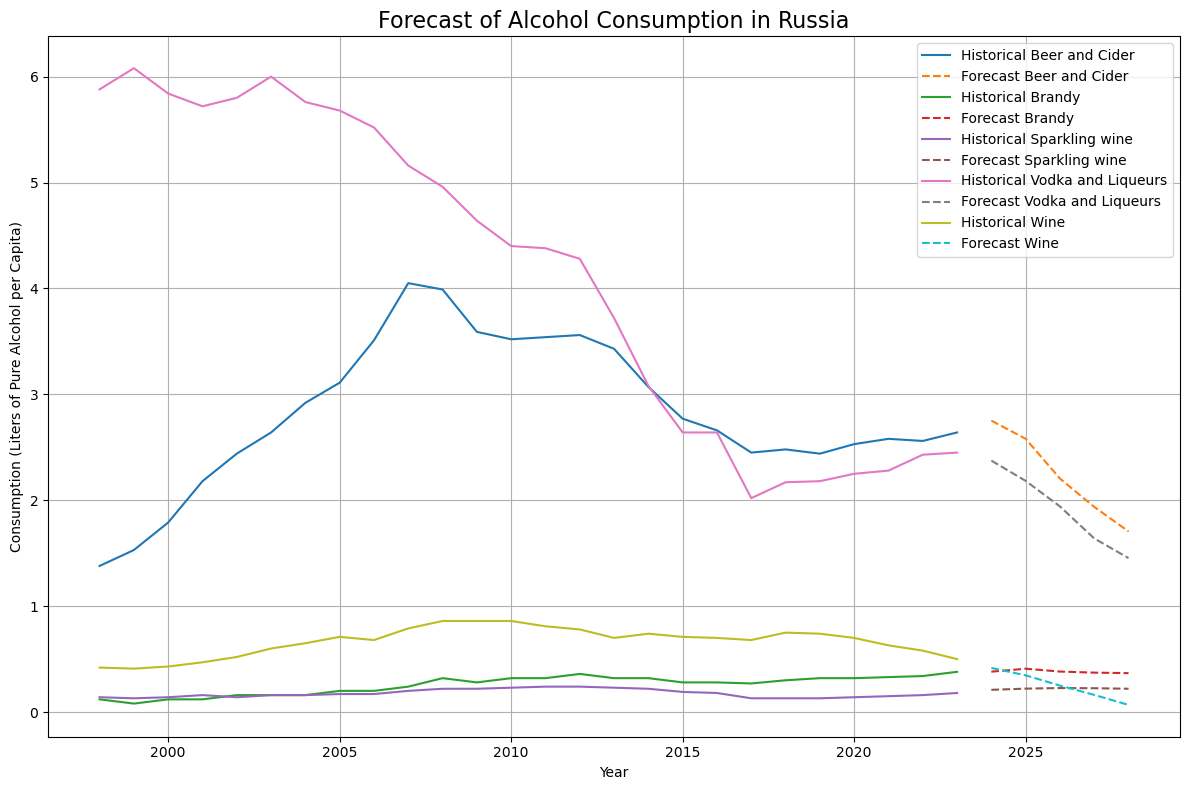

In [89]:
plt.figure(figsize=(12, 8))
for col in df_wide.columns:
    plt.plot(df_wide.index, df_wide[col], label=f'Historical {col}')
    plt.plot(df_forecast.index, df_forecast[col], label=f'Forecast {col}', linestyle='--')

plt.title('Forecast of Alcohol Consumption in Russia', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Consumption (Liters of Pure Alcohol per Capita)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('consumption_forecast.png')

print("\nForecast generated and plot saved as 'consumption_forecast.png'")
print("\nForecasted Values (in Liters per Capita):")
print(df_forecast.round(2))

### **Impulse Response Function Analysis**

Impulse Response Function (IRF) analysis is used to understand the effect of a one-time shock to one of the variables on the other variables in the system. In this case, we are interested in how a shock to the consumption of one type of alcohol affects the consumption of other types of alcohol.

In [90]:
# We'll calculate the response for 10 periods (years) into the future.
irf = results.irf(periods=10)

#### **Plot the IRF**

The plot function will create a grid of charts. 'orth=True' uses an orthogonalized impulse, which is standard practice to isolate the shock to one variable. 'significance_level=0.05' will show us the 95% confidence intervals.

Adjusted IRF plot has been saved as 'impulse_response_functions_adjusted.png'


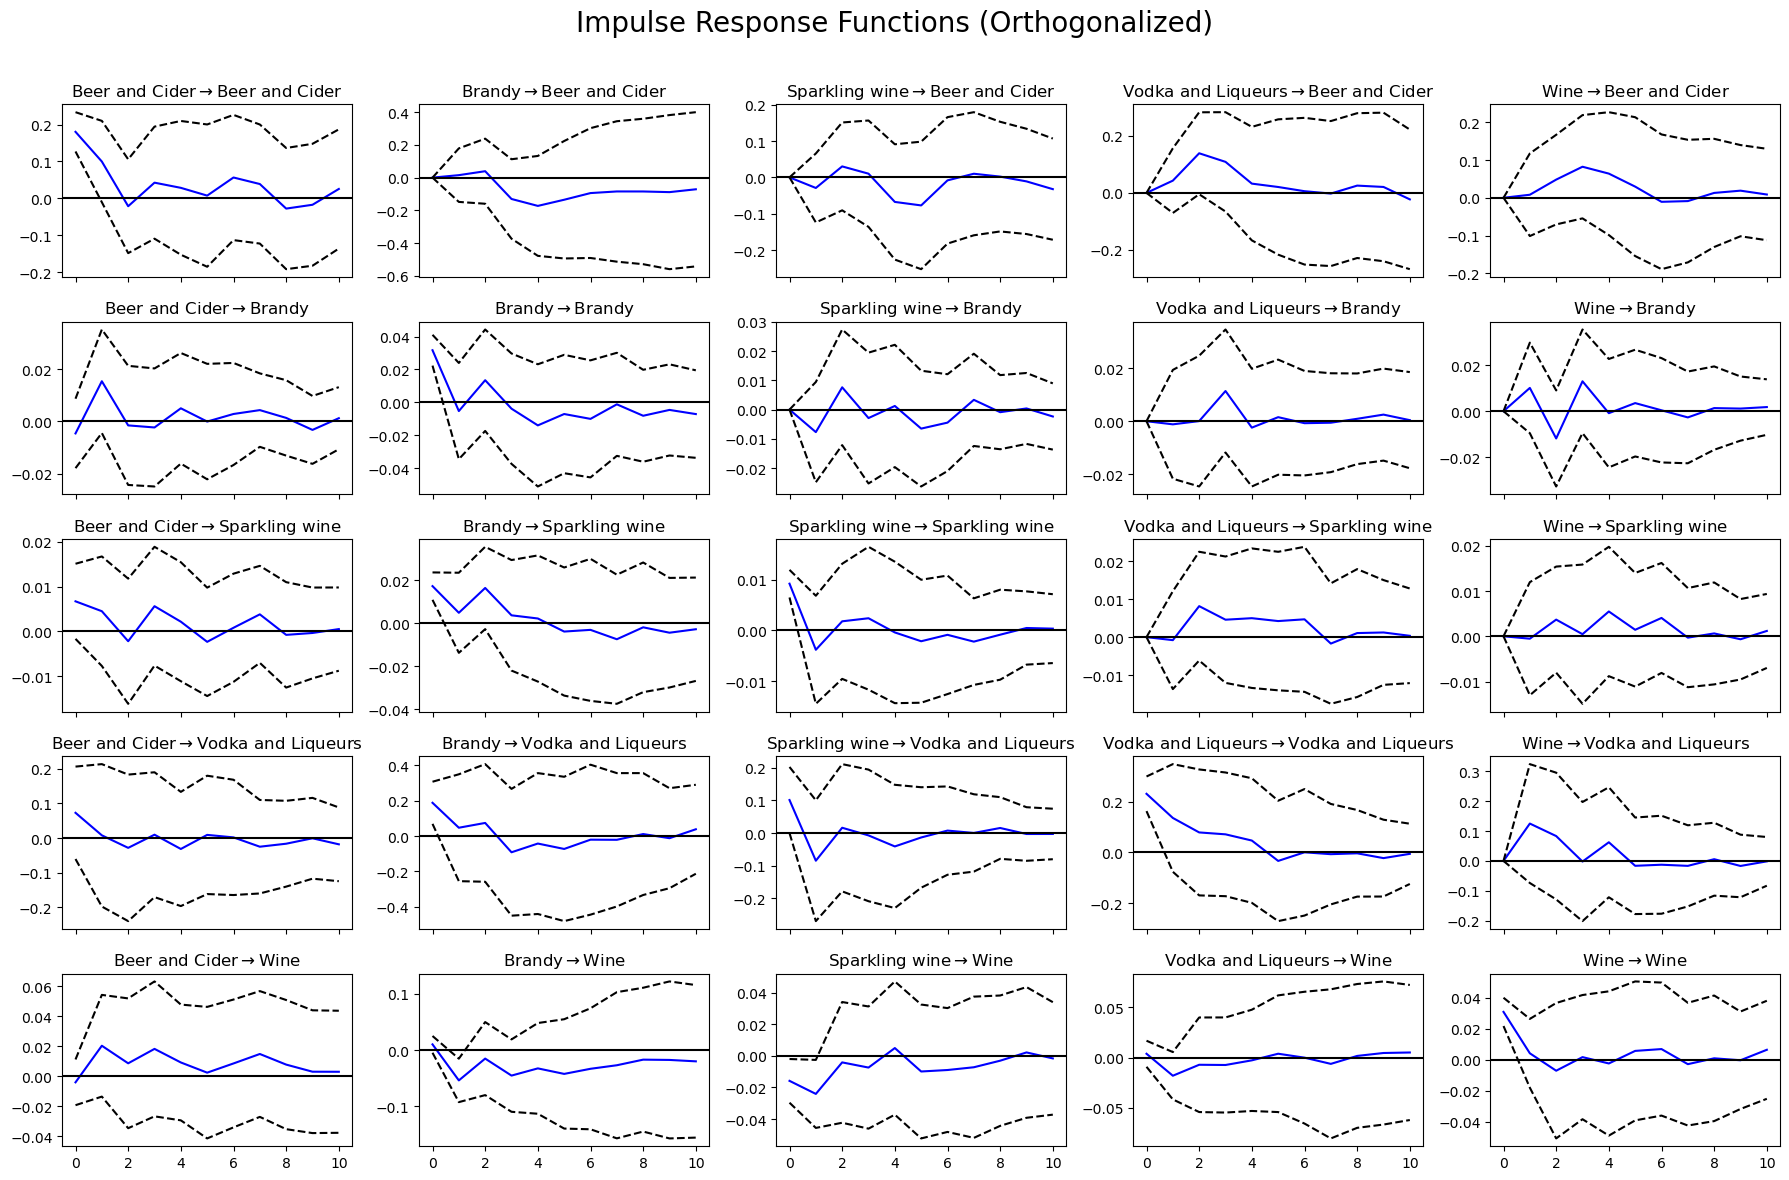

In [91]:
irf = results.irf(periods=10)

fig = irf.plot(orth=True, signif=0.05)
fig.set_size_inches(18, 12)
fig.tight_layout(rect=[0, 0, 1, 0.96]) # rect leaves space for the suptitle
fig.suptitle('Impulse Response Functions (Orthogonalized)', fontsize=20)
plt.savefig('impulse_response_functions_adjusted.png')

print("Adjusted IRF plot has been saved as 'impulse_response_functions_adjusted.png'")

### **Backtesting**

Backtesting is a crucial step in validating a forecasting model. It involves training the model on a subset of the data and then testing its performance on a hold-out period. This helps to ensure that the model is not overfitting to the training data and that it can generalize to new data.

#### **Split the Data**

The data is split into a training set (1998-2019) and a test set (2020-2023).

In [92]:
cutoff_year = 2019
train_data = df_wide[df_wide.index <= cutoff_year]
test_data = df_wide[df_wide.index > cutoff_year]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Test data from {test_data.index.min()} to {test_data.index.max()}")

Training data from 1998 to 2019
Test data from 2020 to 2023


#### **Re-Train the Model on the Training Set**

The VAR model is re-trained on the training set.

In [93]:
train_stationary = train_data.diff().dropna()
model = VAR(train_stationary)

# Let's use a lag order of 1 for simplicity in this validation.
# A more complex approach would re-run lag selection on the training data.
lag_order = 1
results = model.fit(lag_order)

#### **Forecast the Hold-Out Period**

The re-trained model is used to forecast the hold-out period (2020-2023).

In [94]:
last_observations = train_stationary.values[-lag_order:]
forecast_steps = len(test_data)

forecast_diff = results.forecast(y=last_observations, steps=forecast_steps)
df_forecast_diff = pd.DataFrame(forecast_diff, index=test_data.index, columns=df_wide.columns)

# Invert the transformation to get the forecast back to the original scale
last_actual_values = train_data.iloc[-1]
df_forecast = df_forecast_diff.cumsum() + last_actual_values

#### **Compare and Evaluate**

The forecasted values are compared to the actual values in the test set. The Mean Absolute Error (MAE) is calculated to evaluate the performance of the model.


Backtesting plot saved as 'backtesting_validation_plot.png'

--- Mean Absolute Error (MAE) for Forecast Period ---
Beer and Сider      : 0.1183
Brandy              : 0.0147
Sparkling wine      : 0.0334
Vodka and Liqueurs  : 0.8098
Wine                : 0.1303


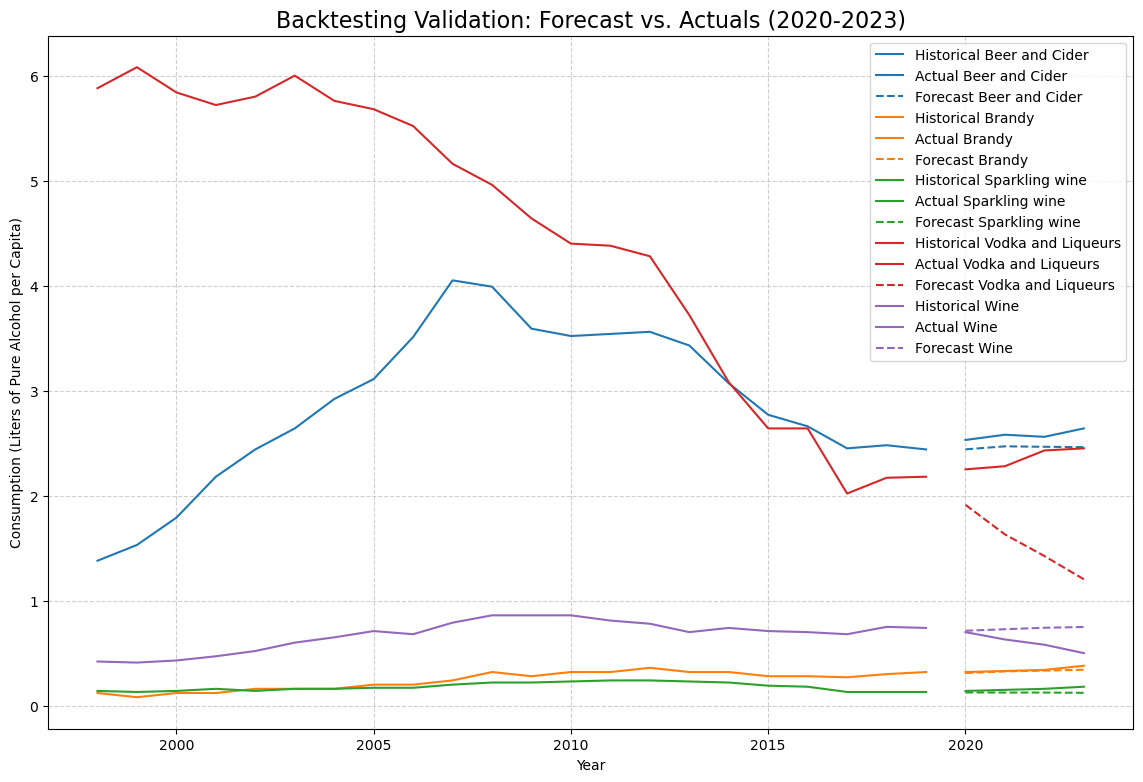

In [95]:
# Visual Comparison
plt.figure(figsize=(14, 9))
for col in df_wide.columns:
    plt.plot(train_data.index, train_data[col], label=f'Historical {col}', color=plt.cm.tab10(df_wide.columns.get_loc(col)))
    plt.plot(test_data.index, test_data[col], label=f'Actual {col}', color=plt.cm.tab10(df_wide.columns.get_loc(col)), linestyle='-')
    plt.plot(df_forecast.index, df_forecast[col], label=f'Forecast {col}', color=plt.cm.tab10(df_wide.columns.get_loc(col)), linestyle='--')

plt.title('Backtesting Validation: Forecast vs. Actuals (2020-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Consumption (Liters of Pure Alcohol per Capita)')
# Create a cleaner legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('backtesting_validation_plot.png')
print("\nBacktesting plot saved as 'backtesting_validation_plot.png'")

# Quantitative Comparison (Mean Absolute Error)
print("\n--- Mean Absolute Error (MAE) for Forecast Period ---")
for col in df_wide.columns:
    mae = mean_absolute_error(test_data[col], df_forecast[col])
    print(f"{col:<20}: {mae:.4f}")

### **VARMAX Model**

The Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX) model is an extension of the VAR model that allows for the inclusion of exogenous variables. In this case, we will use the COVID-19 pandemic as an exogenous variable to see if it improves the forecast.

In [96]:
# Suppress convergence warnings from statsmodels for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

#### **Create the Exogenous Variable**

A binary flag is created to indicate the years of the COVID-19 pandemic (2020 onwards).

In [97]:
# We create a simple binary flag for the 'shock' period (2020 onwards).
df_wide['event_flag'] = (df_wide.index >= 2020).astype(int)

#### **Split the Data (Endogenous and Exogenous)**

The data is split into endogenous (the variables we are forecasting) and exogenous (the external context) variables.

In [98]:
cutoff_year = 2019
# Endogenous variables (the ones we are forecasting)
endog_train = df_wide[df_wide.index <= cutoff_year].drop('event_flag', axis=1)
endog_test = df_wide[df_wide.index > cutoff_year].drop('event_flag', axis=1)

# Exogenous variable (the external context)
exog_train = df_wide[df_wide.index <= cutoff_year][['event_flag']]
exog_test = df_wide[df_wide.index > cutoff_year][['event_flag']]

print(f"Training data from {endog_train.index.min()} to {endog_train.index.max()}")
print(f"Test data from {endog_test.index.min()} to {endog_test.index.max()}")

Training data from 1998 to 2019
Test data from 2020 to 2023


#### **Re-Train Using the VARMAX Model**

The VARMAX model is trained on the training data.

In [99]:
train_stationary = endog_train.diff().dropna()
# We also need to align our exogenous training data by dropping the first row
exog_train_aligned = exog_train.iloc[1:]

# The VARMAX model requires an 'order' (p, q). For a simple VARX, we set q=0.
lag_order = 1 # p
model_order = (lag_order, 0) # (p, q)

# Instantiate the VARMAX model
model = VARMAX(train_stationary, exog=exog_train_aligned, order=model_order)
results = model.fit(disp=False)

#### **Forecast with Exogenous Variables**

The VARMAX model is used to forecast the hold-out period.

In [100]:
# The forecast method now requires the future values of the exogenous variables.
forecast_diff = results.forecast(steps=len(endog_test), exog=exog_test)

# Invert the transformation to get the forecast back to the original scale
last_actual_values = endog_train.iloc[-1]
df_forecast_v2 = forecast_diff.cumsum() + last_actual_values

/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### **Compare and Evaluate**

The forecasted values are compared to the actual values in the test set. The Mean Absolute Error (MAE) is calculated to evaluate the performance of the model.

In [101]:
print("\n--- Mean Absolute Error (MAE) with VARMAX Model ---")
for col in df_wide.columns.drop('event_flag'):
    mae = mean_absolute_error(endog_test[col], df_forecast_v2[col])
    print(f"{col:<20}: {mae:.4f}")


--- Mean Absolute Error (MAE) with VARMAX Model ---
Beer and Сider      : 0.0802
Brandy              : 0.0163
Sparkling wine      : 0.0359
Vodka and Liqueurs  : 0.7516
Wine                : 0.1346
